# Problem Statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

 

For many incumbent operators, retaining high profitable customers is the number one business goal.

 

To reduce customer churn, telecom companies need to predict which customers are at high risk of churn.

 

In this project, you will analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.

 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA,IncrementalPCA
from sklearn.metrics import roc_auc_score,roc_curve,confusion_matrix,accuracy_score,classification_report,recall_score,precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import statsmodels.api as sm
pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows',500)

In [2]:
df=pd.read_csv('C:/Users/manis/Downloads/telecom_churn_data.csv')

In [3]:
#rename columns -aug_vbc_3g,jul_vbc_3g,sep_vbc_3g
df.rename(columns={'jul_vbc_3g':'vbc_3g_7','jun_vbc_3g':'vbc_3g_6','aug_vbc_3g':'vbc_3g_8','sep_vbc_3g':'vbc_3g_9'},inplace=True)

In [4]:
df.duplicated().sum()
#no duplicates

0

In [5]:
#When date_of_last_rech_data_6 is missing means no data recharge happened. Hence impute corresponding numerical columns to 0
df[['total_rech_data_6','max_rech_data_6','count_rech_2g_6','count_rech_3g_6','av_rech_amt_data_6','arpu_3g_6','arpu_2g_6']]=df[['total_rech_data_6','max_rech_data_6','count_rech_2g_6','count_rech_3g_6','av_rech_amt_data_6','arpu_3g_6','arpu_2g_6']].fillna(0)
#When date_of_last_rech_data_7 is missing means no data recharge happened. Hence impute corresponding numerical columns to 0
df[['total_rech_data_7','max_rech_data_7','count_rech_2g_7','count_rech_3g_7','av_rech_amt_data_7','arpu_3g_7','arpu_2g_7']]=df[['total_rech_data_7','max_rech_data_7','count_rech_2g_7','count_rech_3g_7','av_rech_amt_data_7','arpu_3g_7','arpu_2g_7']].fillna(0)
#When date_of_last_rech_data_8 is missing means no data recharge happened. Hence impute corresponding numerical columns to 0
df[['total_rech_data_8','max_rech_data_8','count_rech_2g_8','count_rech_3g_8','av_rech_amt_data_8','arpu_3g_8','arpu_2g_8']]=df[['total_rech_data_8','max_rech_data_8','count_rech_2g_8','count_rech_3g_8','av_rech_amt_data_8','arpu_3g_8','arpu_2g_8']].fillna(0)
#When date_of_last_rech_data_9 is missing means no data recharge happened. Hence impute corresponding numerical columns to 0
df[['total_rech_data_9','max_rech_data_9','count_rech_2g_9','count_rech_3g_9','av_rech_amt_data_9','arpu_3g_9','arpu_2g_9']]=df[['total_rech_data_9','max_rech_data_9','count_rech_2g_9','count_rech_3g_9','av_rech_amt_data_9','arpu_3g_9','arpu_2g_9']].fillna(0)


In [6]:
df['total_rech_amount_data_6']=df['av_rech_amt_data_6']*df['total_rech_data_6']
df['total_rech_amount_data_7']=df['av_rech_amt_data_7']*df['total_rech_data_7']
df['total_rech_amount_data_8']=df['av_rech_amt_data_8']*df['total_rech_data_8']
df['total_rech_amount_data_9']=df['av_rech_amt_data_9']*df['total_rech_data_9']
df['total_recharge_amount_6']=df['total_rech_amt_6']+df['total_rech_amount_data_6']
df['total_recharge_amount_7']=df['total_rech_amt_7']+df['total_rech_amount_data_7']
df['total_recharge_amount_8']=df['total_rech_amt_8']+df['total_rech_amount_data_8']
df['total_recharge_amount_9']=df['total_rech_amt_9']+df['total_rech_amount_data_9']
df['avg_recharge_amount_6_7']=(df['total_recharge_amount_6']+df['total_recharge_amount_7'])/2
df1=df[df['avg_recharge_amount_6_7']>df['avg_recharge_amount_6_7'].quantile(0.7)]
df1.shape

(29953, 235)

In [7]:
df.drop(columns=['total_rech_amount_data_6','total_rech_amount_data_7','total_rech_amount_data_8','total_rech_amount_data_9','total_recharge_amount_6','total_recharge_amount_7','total_recharge_amount_8','total_recharge_amount_9','avg_recharge_amount_6_7'],axis=1,inplace=True)

In [8]:
#create new column for churn since there are no missings
df1['churn']=df1.apply(lambda x: 1 if ((x.total_ic_mou_9==0) & (x.total_og_mou_9==0) & (x.vol_2g_mb_9==0) & (x.vol_3g_mb_9==0)) else 0,axis=1)

C:\Users\manis\AppData\Local\Temp/ipykernel_9728/1204559295.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['churn']=df1.apply(lambda x: 1 if ((x.total_ic_mou_9==0) & (x.total_og_mou_9==0) & (x.vol_2g_mb_9==0) & (x.vol_3g_mb_9==0)) else 0,axis=1)


In [9]:
#drop all 9th month columns
col_9 = [i for i in df1.columns if i[-1]=='9']
df1.drop(columns=col_9,axis=1,inplace=True)

C:\Users\manis\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [10]:
df1.drop(columns=['mobile_number','circle_id'],axis=1,inplace=True)


In [11]:
df1.columns[df1.nunique()==1]

Index(['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
       'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
       'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8',
       'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8'],
      dtype='object')

In [12]:

#drop columns with 0 variance
df1.drop(columns=df1.columns[df1.nunique()==1],axis=1,inplace=True)

In [13]:
df1.drop(columns=[i for i in df1.columns if 'date' in i], axis=1,inplace=True)

In [14]:
df1.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,vbc_3g_8,vbc_3g_7,vbc_3g_6,total_rech_amount_data_6,total_rech_amount_data_7,total_rech_amount_data_8,total_recharge_amount_6,total_recharge_amount_7,total_recharge_amount_8,avg_recharge_amount_6_7,churn
0,197.385,214.816,213.803,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.0,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,4.13,NaN,NaN,1.15,NaN,NaN,5.44,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,0.00,0.00,5.44,NaN,NaN,0.0,NaN,NaN,0.00,NaN,NaN,0.00,4,3,2,362,252,252,252,252,252,252,252,252,1.0,1.0,1.0,252.0,252.0,252.0,0.0,0.0,0.0,1.0,1.0,1.0,252.0,252.0,252.0,30.13,1.32,5.75,83.57,150.76,109.61,212.17,212.17,212.17,212.17,212.17,212.17,0.0,0.0,0.0,0,0,0,0,0,0,1,1,1,0,0,0,1.0,1.0,1.0,968,30.40,0.00,101.20,252.0,252.0,252.0,614.0,504.0,504.0,559.0,1
7,1069.180,1349.850,3171.480,57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.0,0.0,0.00,422.16,533.91,255.79,4.30,23.29,12.01,49.89,31.76,49.14,6.66,20.08,16.68,60.86,75.14,77.84,0.0,0.18,10.01,4.5,0.0,6.50,0.0,0.0,0.0,487.53,609.24,350.16,58.14,32.26,27.31,217.56,221.49,121.19,152.16,101.46,39.53,427.88,355.23,188.04,36.89,11.83,30.39,91.44,126.99,141.33,52.19,34.24,22.21,180.54,173.08,193.94,626.46,558.04,428.74,0.21,0.0,0.0,2.06,14.53,31.59,15.74,15.19,15.14,5,5,7,1580,790,3638,1580,790,1580,0,0,779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,802,57.74,19.38,18.74,0.0,0.0,0.0,1580.0,790.0,3638.0,1185.0,1
8,378.721,492.223,137.362,413.69,351.03,35.08,94.66,80.63,136.48,0.00,0.00,0.00,0.00,0.00,0.00,297.13,217.59,12.49,8

In [15]:
#check mins of usage
cols_mou_6=[i for i in df1.columns if ((i[-1]=='6') & ('_mou' in i))]
cols_mou_6

['onnet_mou_6',
 'offnet_mou_6',
 'roam_ic_mou_6',
 'roam_og_mou_6',
 'loc_og_t2t_mou_6',
 'loc_og_t2m_mou_6',
 'loc_og_t2f_mou_6',
 'loc_og_t2c_mou_6',
 'loc_og_mou_6',
 'std_og_t2t_mou_6',
 'std_og_t2m_mou_6',
 'std_og_t2f_mou_6',
 'std_og_mou_6',
 'isd_og_mou_6',
 'spl_og_mou_6',
 'total_og_mou_6',
 'loc_ic_t2t_mou_6',
 'loc_ic_t2m_mou_6',
 'loc_ic_t2f_mou_6',
 'loc_ic_mou_6',
 'std_ic_t2t_mou_6',
 'std_ic_t2m_mou_6',
 'std_ic_t2f_mou_6',
 'std_ic_mou_6',
 'total_ic_mou_6',
 'spl_ic_mou_6',
 'isd_ic_mou_6']

In [16]:
#since all the columns are na for same rows and total_ic_mou_6 and total_og_mou_6 are 0, hence we can impute nan to 0

df1[cols_mou_6]=df1[cols_mou_6].fillna(0)

C:\Users\manis\anaconda3\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [17]:
cols_mou_7=[i for i in df1.columns if ((i[-1]=='7') & ('_mou' in i))]

df1[cols_mou_7]=df1[cols_mou_7].fillna(0)
cols_mou_8=[i for i in df1.columns if ((i[-1]=='8') & ('_mou' in i))]
df1[cols_mou_8]=df1[cols_mou_8].fillna(0)

In [18]:
df1.loc[:,df1.isna().sum()>0].isna().sum()

og_others_6           542
og_others_7           536
og_others_8          1172
ic_others_6           542
ic_others_7           536
ic_others_8          1172
night_pck_user_6    13213
night_pck_user_7    12915
night_pck_user_8    14018
fb_user_6           13213
fb_user_7           12915
fb_user_8           14018
dtype: int64

In [19]:
df1.drop(columns=['night_pck_user_6','night_pck_user_7','night_pck_user_8','fb_user_6','fb_user_7','fb_user_8'],axis=1,inplace=True)

C:\Users\manis\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [20]:
df1=df1.fillna(0)

In [21]:
df1.isna().sum()

arpu_6                      0
arpu_7                      0
arpu_8                      0
onnet_mou_6                 0
onnet_mou_7                 0
onnet_mou_8                 0
offnet_mou_6                0
offnet_mou_7                0
offnet_mou_8                0
roam_ic_mou_6               0
roam_ic_mou_7               0
roam_ic_mou_8               0
roam_og_mou_6               0
roam_og_mou_7               0
roam_og_mou_8               0
loc_og_t2t_mou_6            0
loc_og_t2t_mou_7            0
loc_og_t2t_mou_8            0
loc_og_t2m_mou_6            0
loc_og_t2m_mou_7            0
loc_og_t2m_mou_8            0
loc_og_t2f_mou_6            0
loc_og_t2f_mou_7            0
loc_og_t2f_mou_8            0
loc_og_t2c_mou_6            0
loc_og_t2c_mou_7            0
loc_og_t2c_mou_8            0
loc_og_mou_6                0
loc_og_mou_7                0
loc_og_mou_8                0
std_og_t2t_mou_6            0
std_og_t2t_mou_7            0
std_og_t2t_mou_8            0
std_og_t2m

In [22]:
df1.corr()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,vbc_3g_8,vbc_3g_7,vbc_3g_6,total_rech_amount_data_6,total_rech_amount_data_7,total_rech_amount_data_8,total_recharge_amount_6,total_recharge_amount_7,total_recharge_amount_8,avg_recharge_amount_6_7,churn
arpu_6,1.000000,0.671846,0.612987,0.342260,0.215989,0.186672,0.509260,0.339561,0.285630,0.126893,0.083509,0.090328,0.196093,0.143347,0.124921,0.167210,0.127556,0.123628,0.332242,0.245107,0.218248,0.139404,0.114370,0.104217,0.047532,0.010440,0.012606,0.328905,0.246137,0.223297,0.273954,0.161416,0.133698,0.301526,0.181611,0.140215,0.066667,0.053517,0.043861,0.385718,0.230442,0.182271,0.467008,0.420852,0.413600,0.122595,0.068867,0.045086,0.054719,2.434622e-02,0.015483,0.554358,0.363330,0.302143,0.082688,0.062846,0.062760,0.188477,0.149110,1.241241e-01,0.051415,0.039162,0.037287,0.181713,0.142376,0.124100,0.088031,0.061527,0.056840,0.098709,0.065808,0.063078,0.034410,0.032510,0.022898,0.125032,0.085703,0.079458,0.225813,0.168902,0.150710,0.031316,-0.034175,-0.011413,0.103025,0.063114,0.070579,0.016130,0.023872,0.012220,0.349587,0.135940,0.119395,0.946104,0.650738,0.604021,0.337938,0.262047,0.284594,0.266615,0.207485,0.199383,-0.109202,-0.175771,-0.122257,0.072743,-0.021833,0.025218,-0.165722,-0.208768,-0.161987,0.090339,0.020062,0.035046,0.115294,-0.026583,0.029188,-0.062502,-0.098918,-0.077884,0.152422,0.070134,0.084636,0.246331,0.116942,0.137999,0.218435,0.094143,0.118915,-0.038924,-0.083953,-0.061163,-0.158638,-0.194203,-0.152276,0.176303,0.080919,0.103636,-0.002644,-0.025318,-0.017510,0.041525,0.058542,0.055092,0.112315,0.088875,-0.023925,0.003281,0.419394,0.210553,0.207504,0.368187,0.067672
arpu_7,0.671846,1.000000,0.759924,0.211715,0.320643,0.270122,0.351859,0.490103,0.395775,0.092420,0.093685,0.093922,0.133450,0.179964,0.152156,0.106512,0.157765,0.135188,0.215368,0.303111,0.255917,0.111984,0.140880,0.121764,0.009023,0.040303,0.032772,0.213333,0.304366,0.255694,0.166831,0.260653,0.219759,0.203977,0.307

In [23]:
xx=pd.DataFrame(df1.corr())

In [24]:
for i in xx.columns:
    for j in xx.loc[:,i].index:
        if(xx.loc[j,i]>0.75):
            print(i,' ',j, ' ',xx.loc[j,i])

arpu_6   arpu_6   1.0
arpu_6   total_rech_amt_6   0.9461040178436977
arpu_7   arpu_7   1.0
arpu_7   arpu_8   0.7599236524955838
arpu_7   total_rech_amt_7   0.9435712302619468
arpu_7   total_rech_amt_8   0.7545218362132544
arpu_8   arpu_7   0.7599236524955838
arpu_8   arpu_8   1.0
arpu_8   total_rech_amt_7   0.7564609938515798
arpu_8   total_rech_amt_8   0.955321586238787
onnet_mou_6   onnet_mou_6   1.0
onnet_mou_6   onnet_mou_7   0.7509067941412094
onnet_mou_6   std_og_t2t_mou_6   0.8593283045582824
onnet_mou_7   onnet_mou_6   0.7509067941412094
onnet_mou_7   onnet_mou_7   1.0
onnet_mou_7   onnet_mou_8   0.8060930596685699
onnet_mou_7   std_og_t2t_mou_7   0.8603138197236057
onnet_mou_8   onnet_mou_7   0.8060930596685699
onnet_mou_8   onnet_mou_8   1.0
onnet_mou_8   std_og_t2t_mou_8   0.8606484158174965
offnet_mou_6   offnet_mou_6   1.0
offnet_mou_6   std_og_t2m_mou_6   0.8303407708667101
offnet_mou_7   offnet_mou_7   1.0
offnet_mou_7   offnet_mou_8   0.7679334583359918
offnet_mou_7   s

In [25]:
df1.drop(columns=['total_rech_amt_6','arpu_8','total_rech_amt_7','total_rech_amt_8','onnet_mou_6','std_og_t2t_mou_6','onnet_mou_7','std_og_t2m_mou_6','offnet_mou_8','std_og_t2m_mou_7'],axis=1,inplace=True)

In [26]:
xx=pd.DataFrame(df1.corr())
for i in xx.columns:
    for j in xx.loc[:,i].index:
        if(xx.loc[j,i]>0.75):
            print(i,' ',j, ' ',xx.loc[j,i])

arpu_6   arpu_6   1.0
arpu_7   arpu_7   1.0
onnet_mou_8   onnet_mou_8   1.0
onnet_mou_8   std_og_t2t_mou_8   0.8606484158174965
offnet_mou_6   offnet_mou_6   1.0
offnet_mou_7   offnet_mou_7   1.0
roam_ic_mou_6   roam_ic_mou_6   1.0
roam_ic_mou_7   roam_ic_mou_7   1.0
roam_ic_mou_8   roam_ic_mou_8   1.0
roam_og_mou_6   roam_og_mou_6   1.0
roam_og_mou_7   roam_og_mou_7   1.0
roam_og_mou_8   roam_og_mou_8   1.0
loc_og_t2t_mou_6   loc_og_t2t_mou_6   1.0
loc_og_t2t_mou_6   loc_og_t2t_mou_7   0.7943956777739565
loc_og_t2t_mou_6   loc_og_mou_6   0.7534279086812217
loc_og_t2t_mou_7   loc_og_t2t_mou_6   0.7943956777739565
loc_og_t2t_mou_7   loc_og_t2t_mou_7   1.0
loc_og_t2t_mou_7   loc_og_t2t_mou_8   0.8330784342729728
loc_og_t2t_mou_7   loc_og_mou_7   0.7637702949429583
loc_og_t2t_mou_8   loc_og_t2t_mou_7   0.8330784342729728
loc_og_t2t_mou_8   loc_og_t2t_mou_8   1.0
loc_og_t2t_mou_8   loc_og_mou_8   0.7673965436343213
loc_og_t2m_mou_6   loc_og_t2m_mou_6   1.0
loc_og_t2m_mou_6   loc_og_t2m_mou

In [27]:
df1.drop(columns=['onnet_mou_8','loc_og_t2t_mou_7','loc_og_t2t_mou_6','loc_og_t2t_mou_8','loc_og_t2m_mou_6'],axis=1,inplace=True)

In [28]:
xx=pd.DataFrame(df1.corr())
for i in xx.columns:
    for j in xx.loc[:,i].index:
        if((xx.loc[j,i]>0.75) & (xx.loc[j,i]<1)):
            print(i,' ',j, ' ',xx.loc[j,i])

loc_og_t2m_mou_7   loc_og_t2m_mou_8   0.8236320530074341
loc_og_t2m_mou_7   loc_og_mou_7   0.7740690979666704
loc_og_t2m_mou_8   loc_og_t2m_mou_7   0.8236320530074341
loc_og_t2m_mou_8   loc_og_mou_8   0.7886421916280612
loc_og_t2f_mou_6   loc_og_t2f_mou_7   0.8091148658730273
loc_og_t2f_mou_7   loc_og_t2f_mou_6   0.8091148658730273
loc_og_t2f_mou_7   loc_og_t2f_mou_8   0.7771622320202879
loc_og_t2f_mou_8   loc_og_t2f_mou_7   0.7771622320202879
loc_og_mou_6   loc_og_mou_7   0.8068225050026676
loc_og_mou_7   loc_og_t2m_mou_7   0.7740690979666704
loc_og_mou_7   loc_og_mou_6   0.8068225050026676
loc_og_mou_7   loc_og_mou_8   0.8419009164894563
loc_og_mou_8   loc_og_t2m_mou_8   0.7886421916280612
loc_og_mou_8   loc_og_mou_7   0.8419009164894563
std_og_t2t_mou_7   std_og_t2t_mou_8   0.8021635533972035
std_og_t2t_mou_8   std_og_t2t_mou_7   0.8021635533972035
std_og_t2m_mou_8   std_og_mou_8   0.762876261978641
std_og_t2f_mou_7   std_og_t2f_mou_8   0.785892405422893
std_og_t2f_mou_8   std_og_t2

In [29]:
df1.drop(columns=['loc_og_t2m_mou_7','loc_og_t2m_mou_8','loc_og_t2f_mou_6','loc_og_t2f_mou_7','loc_og_t2f_mou_8','loc_og_mou_7','loc_og_mou_8','std_og_t2t_mou_8'],axis=1,inplace=True)

In [30]:
xx=pd.DataFrame(df1.corr())
for i in xx.columns:
    for j in xx.loc[:,i].index:
        if((xx.loc[j,i]>0.75) & (xx.loc[j,i]<1)):
            print(i,' ',j, ' ',xx.loc[j,i])

std_og_t2m_mou_8   std_og_mou_8   0.762876261978641
std_og_t2f_mou_7   std_og_t2f_mou_8   0.785892405422893
std_og_t2f_mou_8   std_og_t2f_mou_7   0.785892405422893
std_og_mou_6   total_og_mou_6   0.8340831951357058
std_og_mou_7   std_og_mou_8   0.7928898558575401
std_og_mou_7   total_og_mou_7   0.8496827612467549
std_og_mou_8   std_og_t2m_mou_8   0.762876261978641
std_og_mou_8   std_og_mou_7   0.7928898558575401
std_og_mou_8   total_og_mou_8   0.8512024048195657
isd_og_mou_6   isd_og_mou_7   0.9152469368732788
isd_og_mou_6   isd_og_mou_8   0.9181872172035468
isd_og_mou_7   isd_og_mou_6   0.9152469368732788
isd_og_mou_7   isd_og_mou_8   0.9431199940652452
isd_og_mou_8   isd_og_mou_6   0.9181872172035468
isd_og_mou_8   isd_og_mou_7   0.9431199940652452
total_og_mou_6   std_og_mou_6   0.8340831951357058
total_og_mou_7   std_og_mou_7   0.8496827612467549
total_og_mou_7   total_og_mou_8   0.77562272060464
total_og_mou_8   std_og_mou_8   0.8512024048195657
total_og_mou_8   total_og_mou_7   0

In [31]:
df1.drop(columns=['std_og_t2f_mou_8','std_og_mou_7','std_og_mou_8','isd_og_mou_6','isd_og_mou_7','isd_og_mou_8','std_og_mou_6','total_og_mou_7'],axis=1,inplace=True)

In [32]:
xx=pd.DataFrame(df1.corr())
for i in xx.columns:
    for j in xx.loc[:,i].index:
        if((xx.loc[j,i]>0.75) & (xx.loc[j,i]<1)):
            print(i,' ',j, ' ',xx.loc[j,i])

loc_ic_t2t_mou_6   loc_ic_t2t_mou_7   0.8018080683120015
loc_ic_t2t_mou_7   loc_ic_t2t_mou_6   0.8018080683120015
loc_ic_t2t_mou_7   loc_ic_t2t_mou_8   0.8068153264314692
loc_ic_t2t_mou_8   loc_ic_t2t_mou_7   0.8068153264314692
loc_ic_t2m_mou_6   loc_ic_t2m_mou_7   0.7914029517842258
loc_ic_t2m_mou_6   loc_ic_mou_6   0.8450377305026588
loc_ic_t2m_mou_6   total_ic_mou_6   0.7597229269919672
loc_ic_t2m_mou_7   loc_ic_t2m_mou_6   0.7914029517842258
loc_ic_t2m_mou_7   loc_ic_t2m_mou_8   0.8124488617625967
loc_ic_t2m_mou_7   loc_ic_mou_7   0.8352130831470955
loc_ic_t2m_mou_8   loc_ic_t2m_mou_7   0.8124488617625967
loc_ic_t2m_mou_8   loc_ic_mou_8   0.8488033917248724
loc_ic_t2m_mou_8   total_ic_mou_8   0.7687470867276143
loc_ic_t2f_mou_7   loc_ic_t2f_mou_8   0.7810744803387342
loc_ic_t2f_mou_8   loc_ic_t2f_mou_7   0.7810744803387342
loc_ic_mou_6   loc_ic_t2m_mou_6   0.8450377305026588
loc_ic_mou_6   loc_ic_mou_7   0.8210010931368142
loc_ic_mou_6   total_ic_mou_6   0.8964444858961201
loc_ic_m

In [33]:
df1.drop(columns=['avg_recharge_amount_6_7','total_recharge_amount_8','total_recharge_amount_7','total_recharge_amount_6','total_rech_amount_data_7','total_rech_amount_data_6'],axis=1,inplace=True)
df1.drop(columns=['sachet_3g_8','sachet_3g_7','sachet_3g_6','monthly_3g_8','monthly_3g_7','monthly_3g_6','sachet_2g_8','sachet_2g_7','sachet_2g_6'],axis=1,inplace=True)
df1.drop(columns=['arpu_2g_8','arpu_2g_7','arpu_2g_6','arpu_3g_8','arpu_3g_7','arpu_3g_6','vol_3g_mb_8','vol_3g_mb_7','vol_3g_mb_6'],axis=1,inplace=True)
df1.drop(columns=['av_rech_amt_data_8','av_rech_amt_data_7','av_rech_amt_data_6','count_rech_2g_8','count_rech_2g_7','count_rech_2g_6'],axis=1,inplace=True)
df.drop(columns=['total_rech_num_7','total_ic_mou_8','loc_ic_t2m_mou_8','total_ic_mou_7','total_ic_mou_6','std_ic_mou_8','std_ic_mou_7'],axis=1,inplace=True)
df1.drop(columns=['total_rech_num_8','total_ic_mou_8','total_ic_mou_7','total_ic_mou_6','loc_ic_mou_8','loc_ic_mou_7','loc_ic_mou_6'],axis=1,inplace=True)

In [34]:
xx=pd.DataFrame(df1.corr())
for i in xx.columns:
    for j in xx.loc[:,i].index:
        if((xx.loc[j,i]>0.75) & (xx.loc[j,i]<1)):
            print(i,' ',j, ' ',xx.loc[j,i])

loc_ic_t2t_mou_6   loc_ic_t2t_mou_7   0.8018080683120015
loc_ic_t2t_mou_7   loc_ic_t2t_mou_6   0.8018080683120015
loc_ic_t2t_mou_7   loc_ic_t2t_mou_8   0.8068153264314692
loc_ic_t2t_mou_8   loc_ic_t2t_mou_7   0.8068153264314692
loc_ic_t2m_mou_6   loc_ic_t2m_mou_7   0.7914029517842258
loc_ic_t2m_mou_7   loc_ic_t2m_mou_6   0.7914029517842258
loc_ic_t2m_mou_7   loc_ic_t2m_mou_8   0.8124488617625967
loc_ic_t2m_mou_8   loc_ic_t2m_mou_7   0.8124488617625967
loc_ic_t2f_mou_7   loc_ic_t2f_mou_8   0.7810744803387342
loc_ic_t2f_mou_8   loc_ic_t2f_mou_7   0.7810744803387342
std_ic_t2m_mou_6   std_ic_mou_6   0.8141908821721625
std_ic_t2m_mou_7   std_ic_mou_7   0.8194438677584504
std_ic_t2m_mou_8   std_ic_mou_8   0.8457869677527743
std_ic_mou_6   std_ic_t2m_mou_6   0.8141908821721625
std_ic_mou_7   std_ic_t2m_mou_7   0.8194438677584504
std_ic_mou_8   std_ic_t2m_mou_8   0.8457869677527743


In [35]:
df1.drop(columns=['std_ic_mou_8','std_ic_mou_6','std_ic_mou_7','loc_ic_t2f_mou_7','loc_ic_t2m_mou_7','loc_ic_t2m_mou_6','loc_ic_t2t_mou_7'],axis=1,inplace=True)

In [36]:
xx=pd.DataFrame(df1.corr())
for i in xx.columns:
    for j in xx.loc[:,i].index:
        if((xx.loc[j,i]>0.75) & (xx.loc[j,i]<1)):
            print(i,' ',j, ' ',xx.loc[j,i])

In [37]:
df1.shape

(29953, 78)

In [38]:
#Convert AON to years and form catergorical varaible
df1['aon']=df1.aon.apply(lambda x: round(x/365,2))

In [39]:
df1['AgeOfNw']=pd.cut(df1.aon,bins=[0,2,5,12],labels=['0-2','2-5','>5'])

In [40]:
df1.drop('aon',axis=1,inplace=True)

In [41]:
cols_mou_6=[i for i in df1.columns if (i[-1]=='6')]
cols_mou_7=[i for i in df1.columns if (i[-1]=='7')]


In [42]:
df1['avg_arpu_6_7']=df1[['arpu_6','arpu_7']].mean(axis=1)

In [43]:
df1.drop(columns=['arpu_6','arpu_7'],axis=1,inplace=True)

In [44]:
df1['offnet_mou_6_7']=(df1['offnet_mou_7']+df1['offnet_mou_6'])/2
df1['roam_ic_mou_6_7']=(df1['roam_ic_mou_7']+df1['roam_ic_mou_6'])/2
df1['roam_og_mou_6_7']=(df1['roam_og_mou_7']+df1['roam_og_mou_6'])/2
df1['loc_og_t2c_mou_6_7']=(df1['loc_og_t2c_mou_7']+df1['loc_og_t2c_mou_6'])/2
df1['spl_og_mou_6_7']=(df1['spl_og_mou_6']+df1['spl_og_mou_7'])/2
df1['og_others_6_7']=(df1['og_others_6']+df1['og_others_7'])/2
df1['std_ic_t2t_mou_6_7']=(df1['std_ic_t2t_mou_7']+df1['std_ic_t2t_mou_6'])/2
df1['std_ic_t2m_mou_6_7']=(df1['std_ic_t2m_mou_7']+df1['std_ic_t2m_mou_6'])/2
df1['std_ic_t2f_mou_6_7']=(df1['std_ic_t2f_mou_7']+df1['std_ic_t2f_mou_6'])/2
df1['spl_ic_mou_6_7']=(df1['spl_ic_mou_7']+df1['spl_ic_mou_6'])/2
df1['isd_ic_mou_6_7']=(df1['isd_ic_mou_7']+df1['isd_ic_mou_6'])/2
df1['ic_others_6_7']=(df1['ic_others_7']+df1['ic_others_6'])/2
df1['total_rech_num_6_7']=(df1['total_rech_num_7']+df1['total_rech_num_6'])/2
df1['max_rech_amt_6_7']=(df1['max_rech_amt_6']+df1['max_rech_amt_7'])/2
df1['last_day_rch_amt_6_7']=(df1['last_day_rch_amt_7']+df1['last_day_rch_amt_6'])/2
df1['total_rech_data_6_7']=(df1['total_rech_data_7']+df1['total_rech_data_6'])/2
df1['max_rech_data_6_7']=(df1['max_rech_data_7']+df1['max_rech_data_6'])/2
df1['count_rech_3g_6_7']=(df1['count_rech_3g_7']+df1['count_rech_3g_6'])/2
df1['vol_2g_mb_6_7']=(df1['vol_2g_mb_6']+df1['vol_2g_mb_7'])/2
df1['monthly_2g_6_7']=(df1['monthly_2g_6']+df1['monthly_2g_7'])/2
df1['vbc_3g_6_7']=(df1['vbc_3g_6']+df1['vbc_3g_7'])/2


In [45]:
df1.drop(columns=['offnet_mou_7','offnet_mou_6','roam_ic_mou_7','roam_ic_mou_6','roam_og_mou_7','roam_og_mou_6','loc_og_t2c_mou_7','loc_og_t2c_mou_6','spl_og_mou_6','spl_og_mou_7','og_others_6','og_others_7','std_ic_t2t_mou_7','std_ic_t2t_mou_6','std_ic_t2m_mou_7','std_ic_t2m_mou_6','std_ic_t2f_mou_7','std_ic_t2f_mou_6','spl_ic_mou_7','spl_ic_mou_6','isd_ic_mou_7','isd_ic_mou_6','ic_others_7','ic_others_6','total_rech_num_7','total_rech_num_6','max_rech_amt_6','max_rech_amt_7','last_day_rch_amt_7','last_day_rch_amt_6','total_rech_data_7','total_rech_data_6','max_rech_data_7','max_rech_data_6','count_rech_3g_7','count_rech_3g_6','vol_2g_mb_6','vol_2g_mb_7','monthly_2g_6','monthly_2g_7','vbc_3g_6','vbc_3g_7'],axis=1,inplace=True)

In [46]:
dd=pd.get_dummies(df1.AgeOfNw,drop_first=True)
df1=pd.concat([df1,dd],axis=1)
df1.drop('AgeOfNw',axis=1,inplace=True)

In [47]:
df1.shape

(29953, 57)

In [48]:
y=df1['churn']
X=df1.drop('churn',axis=1)

In [49]:
#divide to train test split
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.7,random_state=42,stratify=y)

In [50]:
y_train.sum()

1703

In [51]:
y_test.sum() *100/len(y_test)

8.123748052526151

There is class imbalance

In [52]:
from imblearn.over_sampling import SMOTE
smt= SMOTE(random_state=42)
X_train_smote,y_train_smote=smt.fit_resample(X_train,y_train)

In [53]:
#Build Tree model
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

params={'max_depth':[10,20,30,50,100],'min_samples_split':[.1,.2,.3,.5],'max_features':[.1,.2,.3,.4,.5]}

dt=DecisionTreeClassifier()
model1=GridSearchCV(estimator=dt,scoring='recall',cv=5,verbose=-1,n_jobs=-1,param_grid=params)
model1.fit(X_train_smote,y_train_smote)


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, 50, 100],
                         'max_features': [0.1, 0.2, 0.3, 0.4, 0.5],
                         'min_samples_split': [0.1, 0.2, 0.3, 0.5]},
             scoring='recall', verbose=-1)

In [54]:
model1.best_estimator_

DecisionTreeClassifier(max_depth=10, max_features=0.5, min_samples_split=0.5)

In [55]:
model1.best_score_

0.8846036412402952

In [56]:
#Build Tree model
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

params={'max_depth':[5,20,22,25],'min_samples_split':[.4,.5,.6,.7],'max_features':[.4,.5,.6,.7,.8]}

dt=DecisionTreeClassifier()
model1=GridSearchCV(estimator=dt,scoring='recall',cv=5,verbose=-1,n_jobs=-1,param_grid=params)
model1.fit(X_train_smote,y_train_smote)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 20, 22, 25],
                         'max_features': [0.4, 0.5, 0.6, 0.7, 0.8],
                         'min_samples_split': [0.4, 0.5, 0.6, 0.7]},
             scoring='recall', verbose=-1)

In [57]:
model1.best_estimator_

DecisionTreeClassifier(max_depth=22, max_features=0.7, min_samples_split=0.5)

In [58]:
   model1.best_score_

0.8886006211124883

In [59]:
#Build Tree model
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

params={'max_depth':[20],'min_samples_split':[.5,.52,.55],'max_features':[.8,.9,1]}

dt=DecisionTreeClassifier()
model1=GridSearchCV(estimator=dt,scoring='recall',cv=5,verbose=-1,n_jobs=-1,param_grid=params)
model1.fit(X_train_smote,y_train_smote)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [20], 'max_features': [0.8, 0.9, 1],
                         'min_samples_split': [0.5, 0.52, 0.55]},
             scoring='recall', verbose=-1)

In [60]:
model1.best_estimator_

DecisionTreeClassifier(max_depth=20, max_features=0.8, min_samples_split=0.52)

In [61]:
  model1.best_score_

0.894102827185678

In [62]:
def drawroc(actual,predProb):
    fpr,tpr,threshold=roc_curve(actual,predProb)
    auc=roc_auc_score(actual,predProb)
    plt.plot(fpr,tpr,label='roc auc %2f' %auc)
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.xlim([0,1])
    plt.ylim([0,1.05])
    plt.legend(loc='best')
    plt.show

In [63]:
def metri(df):
    print('accuracy is' , accuracy_score(df.churn,df.predicted))
    print('senstivity is',recall_score(df.churn,df.predicted)) 
    cm=confusion_matrix(df.churn,df.predicted)
    specificity=(cm[0,0])/(cm[0,0]+cm[0,1])
    print('Specificity is',specificity) 
    tempdf=pd.DataFrame(columns=['accuracy','sens','spec'])
    tempdf.loc[0]=[accuracy_score(df.churn,df.predicted),recall_score(df.churn,df.predicted),specificity]
    return tempdf

In [64]:
Tree_Train_res=pd.DataFrame({'churn':y_train_smote,'Churn_prob':model1.best_estimator_.predict_proba(X_train_smote)[:,1]})
Tree_Train_res.set_index(y_train_smote.index)
Tree_Train_res.head()

,churn,Churn_prob
0,0,0.125775
1,0,0.125775
2,0,0.125775
3,0,0.125775
4,0,0.125775


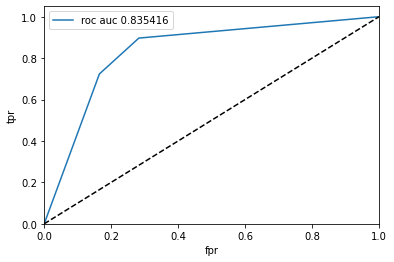

In [65]:
#Roc train
drawroc(Tree_Train_res.churn,Tree_Train_res.Churn_prob)

In [66]:
#Find Ideal cutoff
x=[i/10 for i in range(10)]
for col in x:
    Tree_Train_res[col]=Tree_Train_res.Churn_prob.apply(lambda x: 1 if x>col else 0)
    

In [67]:
Tree_Train_res.head()

,churn,Churn_prob,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.125775,1,1,0,0,0,0,0,0,0,0
1,0,0.125775,1,1,0,0,0,0,0,0,0,0
2,0,0.125775,1,1,0,0,0,0,0,0,0,0
3,0,0.125775,1,1,0,0,0,0,0,0,0,0
4,0,0.125775,1,1,0,0,0,0,0,0,0,0


In [68]:
y=[i/10 for i in range(10)]
y

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [69]:
y=[i/10 for i in range(10)]
cutoff=pd.DataFrame(columns=['prob','specificity','sensitivity','accuracy'])
for i in y:
    cm=confusion_matrix(Tree_Train_res.churn,Tree_Train_res[i])
    specif=cm[0,0]/(cm[0,0]+cm[0,1])
    accu=(cm[0,0]+cm[1,1])/(cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1])
    sens=cm[1,1]/(cm[1,0]+cm[1,1])
    cutoff.loc[i]=[i,specif,sens,accu]
cutoff                   

,prob,specificity,sensitivity,accuracy
0.0,0.0,0.000000,1.000000,0.500000
0.1,0.1,0.000000,1.000000,0.500000
0.2,0.2,0.717297,0.896802,0.807049
0.3,0.3,0.717297,0.896802,0.807049
0.4,0.4,0.717297,0.896802,0.807049
0.5,0.5,0.717297,0.896802,0.807049
0.6,0.6,0.835133,0.723681,0.779407
0.7,0.7,0.835133,0.723681,0.779407
0.8,0.8,0.835133,0.723681,0.779407
0.9,0.9,1.000000,0.000000,0.500000


<AxesSubplot:xlabel='prob'>

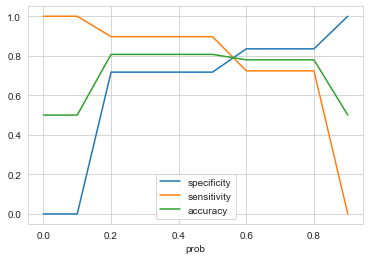

In [70]:
#Find  cutoff
sns.set_style('whitegrid')
cutoff.plot(x='prob',y=['specificity','sensitivity','accuracy'])
#ideal cutoff is .62

In [71]:
#Train predicted
Tree_Train_res['predicted']=Tree_Train_res.Churn_prob.apply(lambda x:1 if x>.62 else 0)

In [72]:
treeTraindf=metri(Tree_Train_res)

accuracy is 0.779407184385382
senstivity is 0.7236814784053156
Specificity is 0.8351328903654485


In [73]:
#Test on test set
Tree_Test_res=pd.DataFrame({'churn':y_test.values})
Tree_Test_res['churn_prob']=model1.best_estimator_.predict_proba(X_test)[:,1]
Tree_Test_res['predicted']=Tree_Test_res.churn_prob.apply(lambda x:1 if x>.62 else 0)
treeTestdf=metri(Tree_Test_res)

accuracy is 0.8268417538393056
senstivity is 0.7232876712328767
Specificity is 0.8359980620155039


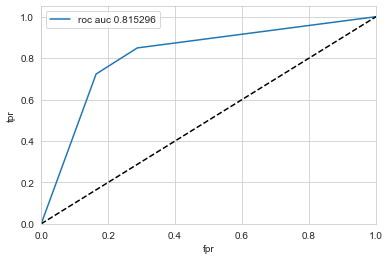

In [74]:
#Roc test
drawroc(Tree_Test_res.churn,Tree_Test_res.churn_prob)

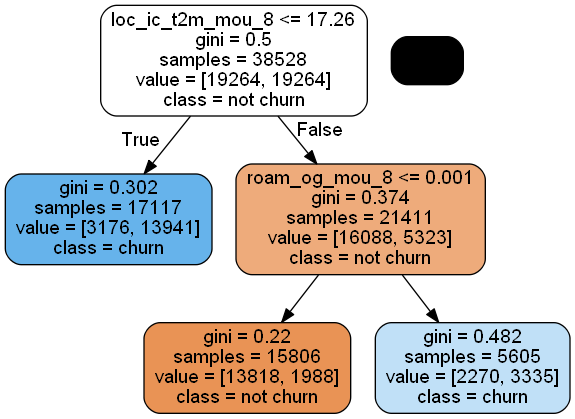

In [75]:
#view Tree
from IPython.display import Image
import pydotplus,graphviz
from sklearn.tree import export_graphviz
from six import StringIO

dot=StringIO()
export_graphviz(model1.best_estimator_,out_file=dot,rounded=True,class_names=['not churn','churn'],filled=True,feature_names=X_train_smote.columns)
graph = pydotplus.graph_from_dot_data(dot.getvalue())
Image(graph.create_png())

In [76]:
model1.best_estimator_.get_params

<bound method BaseEstimator.get_params of DecisionTreeClassifier(max_depth=20, max_features=0.8, min_samples_split=0.52)>

As per Tree MOdel, most import factors for finding churn are - loc_ic_t2t_mou_8 and roam_og_mou_8

In [77]:
overAllScore=pd.DataFrame(columns=['accuracy','sensitivity','specificity'])
overAllScore.loc['TreeTrainWithoutPCA']=[treeTraindf.accuracy[0],treeTraindf.sens[0],treeTraindf.spec[0]]
overAllScore.loc['TreeTestWithoutPCA']=[treeTestdf.accuracy[0],treeTestdf.sens[0],treeTestdf.spec[0]]

In [78]:
overAllScore

,accuracy,sensitivity,specificity
TreeTrainWithoutPCA,0.779407,0.723681,0.835133
TreeTestWithoutPCA,0.826842,0.723288,0.835998


In [81]:
#Random Forest without PCA
from sklearn.ensemble import RandomForestClassifier
rf_model=RandomForestClassifier()
params={'n_estimators':[20,50,70,100,150],'max_depth':[10,20,30],'max_features':[.4,.5,.6],'min_samples_split':[.3,.4,.5,.6]}
rf_m1=GridSearchCV(estimator=rf_model,param_grid=params,cv=5,verbose=-1,n_jobs=-1,scoring='recall')
rf_m1.fit(X_train_smote,y_train_smote)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30],
                         'max_features': [0.4, 0.5, 0.6],
                         'min_samples_split': [0.3, 0.4, 0.5, 0.6],
                         'n_estimators': [20, 50, 70, 100, 150]},
             scoring='recall', verbose=-1)

In [82]:
rf_m1.best_estimator_

RandomForestClassifier(max_depth=20, max_features=0.6, min_samples_split=0.3,
                       n_estimators=20)

In [83]:
rf_m1.best_score_

0.8901055912790913

In [84]:
rf_model=RandomForestClassifier()
params={'n_estimators':[10,5,20,30],'max_depth':[15,20,25],'max_features':[.6,.7,.8,.9],'min_samples_split':[.25,.3,.35,.4]}
rf_m1=GridSearchCV(estimator=rf_model,param_grid=params,cv=5,verbose=-1,n_jobs=-1,scoring='recall')
rf_m1.fit(X_train_smote,y_train_smote)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [15, 20, 25],
                         'max_features': [0.6, 0.7, 0.8, 0.9],
                         'min_samples_split': [0.25, 0.3, 0.35, 0.4],
                         'n_estimators': [10, 5, 20, 30]},
             scoring='recall', verbose=-1)

In [85]:
rf_m1.best_estimator_

RandomForestClassifier(max_depth=20, max_features=0.9, min_samples_split=0.3,
                       n_estimators=5)

In [86]:
rf_m1.best_score_

0.8958679687228385

In [87]:
rf_model=RandomForestClassifier()
params={'n_estimators':[3,5,6,9],'max_depth':[25,30,35],'max_features':[.9,1],'min_samples_split':[.3]}
rf_m1=GridSearchCV(estimator=rf_model,param_grid=params,cv=5,verbose=-1,n_jobs=-1,scoring='recall')
rf_m1.fit(X_train_smote,y_train_smote)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [25, 30, 35], 'max_features': [0.9, 1],
                         'min_samples_split': [0.3],
                         'n_estimators': [3, 5, 6, 9]},
             scoring='recall', verbose=-1)

In [88]:
rf_m1.best_estimator_

RandomForestClassifier(max_depth=25, max_features=0.9, min_samples_split=0.3,
                       n_estimators=5)

In [89]:
rf_m1.best_score_

0.894518236251829

In [90]:
rf_model=RandomForestClassifier(n_estimators=5,max_depth=25, max_features=0.9, min_samples_split=0.3)
rf_model.fit(X_train_smote,y_train_smote)
rf_Train_res=pd.DataFrame({'churn':y_train_smote.values})
rf_Train_res['churn_prob']=rf_model.predict_proba(X_train_smote)[:,1]
rf_Train_res.head()

,churn,churn_prob
0,0,0.123724
1,0,0.123724
2,0,0.123724
3,0,0.123724
4,0,0.123724


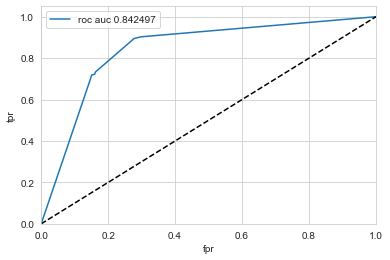

In [91]:
#Random Forest Roc train 
drawroc(rf_Train_res.churn,rf_Train_res.churn_prob)

In [92]:
#find ideal cutoff
x=[i/10 for i in range(10)]
for n in x:
    rf_Train_res[n]=rf_Train_res.churn_prob.apply(lambda x: 1 if x>n else 0)
rf_Train_res.head()

,churn,churn_prob,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.123724,1,1,0,0,0,0,0,0,0,0
1,0,0.123724,1,1,0,0,0,0,0,0,0,0
2,0,0.123724,1,1,0,0,0,0,0,0,0,0
3,0,0.123724,1,1,0,0,0,0,0,0,0,0
4,0,0.123724,1,1,0,0,0,0,0,0,0,0


In [93]:
def find_cutoff(df):
     y=[i/10 for i in range(10)]
     cutoff=pd.DataFrame(columns=['prob','specificity','sensitivity','accuracy'])
     for i in y:
         cm=confusion_matrix(df.churn,df[i])
         specif=cm[0,0]/(cm[0,0]+cm[0,1])
         accu=(cm[0,0]+cm[1,1])/(cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1])
         sens=cm[1,1]/(cm[1,0]+cm[1,1])
         cutoff.loc[i]=[i,specif,sens,accu]
     return cutoff           

In [94]:
cutoff=find_cutoff(rf_Train_res)
cutoff

,prob,specificity,sensitivity,accuracy
0.0,0.0,0.000000,1.000000,0.500000
0.1,0.1,0.000000,1.000000,0.500000
0.2,0.2,0.702398,0.902876,0.802637
0.3,0.3,0.716466,0.897010,0.806738
0.4,0.4,0.716466,0.897010,0.806738
0.5,0.5,0.717297,0.896802,0.807049
0.6,0.6,0.838092,0.732870,0.785481
0.7,0.7,0.849149,0.718127,0.783638
0.8,0.8,0.852004,0.703540,0.777772
0.9,0.9,1.000000,0.000000,0.500000


<AxesSubplot:xlabel='prob'>

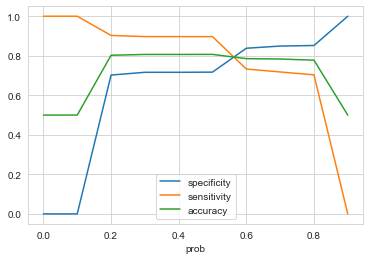

In [95]:
cutoff.plot(x='prob',y=['specificity','sensitivity','accuracy'])
#ideal cutoff is 0.58

In [96]:
rf_Train_res['predicted']=rf_Train_res.churn_prob.apply(lambda x: 1 if x>0.5 else 0)

In [97]:
rfTraindf=metri(rf_Train_res)

accuracy is 0.8070494186046512
senstivity is 0.8968023255813954
Specificity is 0.717296511627907


In [98]:
#Random forest Test on test set
rf_Test_res=pd.DataFrame({'churn':y_test.values})
rf_Test_res['churn_prob']=rf_model.predict_proba(X_test)[:,1]
rf_Test_res['predicted']=rf_Test_res.churn_prob.apply(lambda x:1 if x>0.5 else 0)
rfTestdf=metri(rf_Test_res)

accuracy is 0.7240151346539061
senstivity is 0.8493150684931506
Specificity is 0.7129360465116279


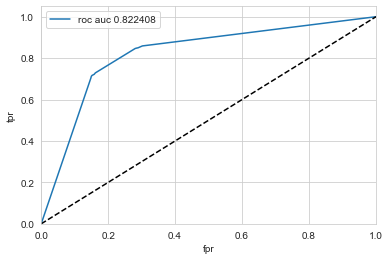

In [99]:
#Random Forest Roc test
drawroc(rf_Test_res.churn,rf_Test_res.churn_prob)

In [100]:
overAllScore.loc['RFTrainWithoutPCA']=[rfTraindf.accuracy[0],rfTraindf.sens[0],rfTraindf.spec[0]]
overAllScore.loc['RFTestWithoutPCA']=[rfTestdf.accuracy[0],rfTestdf.sens[0],rfTestdf.spec[0]]

In [101]:
overAllScore

,accuracy,sensitivity,specificity
TreeTrainWithoutPCA,0.779407,0.723681,0.835133
TreeTestWithoutPCA,0.826842,0.723288,0.835998
RFTrainWithoutPCA,0.807049,0.896802,0.717297
RFTestWithoutPCA,0.724015,0.849315,0.712936


<BarContainer object of 56 artists>

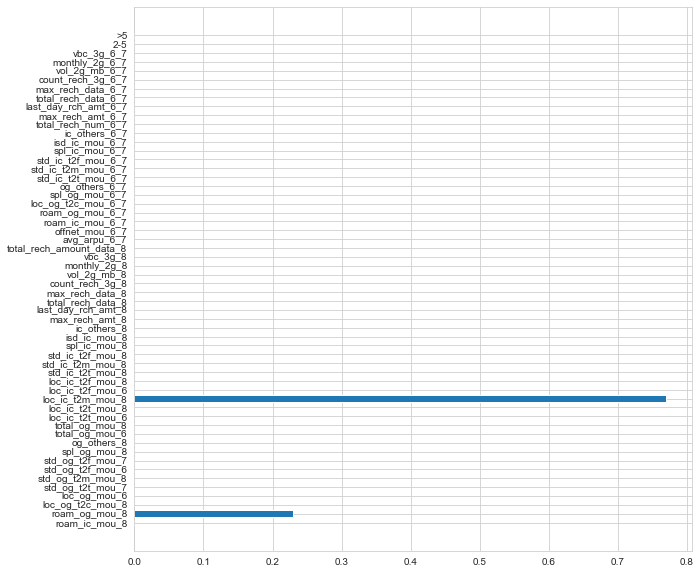

In [102]:
plt.figure(figsize=(10,10))
plt.barh(X_train.columns, rf_model.feature_importances_)

#As per random forest, most important features are ,roam_og_mou_8,

# Logistic Regression without PCA

In [103]:
cols=X_train_smote.columns
cols

Index(['roam_ic_mou_8', 'roam_og_mou_8', 'loc_og_t2c_mou_8', 'loc_og_mou_6',
       'std_og_t2t_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6',
       'std_og_t2f_mou_7', 'spl_og_mou_8', 'og_others_8', 'total_og_mou_6',
       'total_og_mou_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_8',
       'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_8',
       'std_ic_t2t_mou_8', 'std_ic_t2m_mou_8', 'std_ic_t2f_mou_8',
       'spl_ic_mou_8', 'isd_ic_mou_8', 'ic_others_8', 'max_rech_amt_8',
       'last_day_rch_amt_8', 'total_rech_data_8', 'max_rech_data_8',
       'count_rech_3g_8', 'vol_2g_mb_8', 'monthly_2g_8', 'vbc_3g_8',
       'total_rech_amount_data_8', 'avg_arpu_6_7', 'offnet_mou_6_7',
       'roam_ic_mou_6_7', 'roam_og_mou_6_7', 'loc_og_t2c_mou_6_7',
       'spl_og_mou_6_7', 'og_others_6_7', 'std_ic_t2t_mou_6_7',
       'std_ic_t2m_mou_6_7', 'std_ic_t2f_mou_6_7', 'spl_ic_mou_6_7',
       'isd_ic_mou_6_7', 'ic_others_6_7', 'total_rech_num_6_7',
       'max_rech_amt_6_7', 'last_day_r

In [104]:
#standardize the numerical features
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
X_train_smote[['roam_ic_mou_8', 'roam_og_mou_8', 'loc_og_t2c_mou_8', 'loc_og_mou_6',
       'std_og_t2t_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6',
       'std_og_t2f_mou_7', 'spl_og_mou_8', 'og_others_8', 'total_og_mou_6',
       'total_og_mou_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_8',
       'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_8',
       'std_ic_t2t_mou_8', 'std_ic_t2m_mou_8', 'std_ic_t2f_mou_8',
       'spl_ic_mou_8', 'isd_ic_mou_8', 'ic_others_8', 'max_rech_amt_8',
       'last_day_rch_amt_8', 'total_rech_data_8', 'max_rech_data_8',
       'count_rech_3g_8', 'vol_2g_mb_8', 'monthly_2g_8', 'vbc_3g_8',
       'total_rech_amount_data_8', 'avg_arpu_6_7', 'offnet_mou_6_7',
       'roam_ic_mou_6_7', 'roam_og_mou_6_7', 'loc_og_t2c_mou_6_7',
       'spl_og_mou_6_7', 'og_others_6_7', 'std_ic_t2t_mou_6_7',
       'std_ic_t2m_mou_6_7', 'std_ic_t2f_mou_6_7', 'spl_ic_mou_6_7',
       'isd_ic_mou_6_7', 'ic_others_6_7', 'total_rech_num_6_7',
       'max_rech_amt_6_7', 'last_day_rch_amt_6_7', 'total_rech_data_6_7',
       'max_rech_data_6_7', 'count_rech_3g_6_7', 'vol_2g_mb_6_7',
       'monthly_2g_6_7', 'vbc_3g_6_7', '2-5', '>5']]=scaler.fit_transform(X_train_smote[['roam_ic_mou_8', 'roam_og_mou_8', 'loc_og_t2c_mou_8', 'loc_og_mou_6',
       'std_og_t2t_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6',
       'std_og_t2f_mou_7', 'spl_og_mou_8', 'og_others_8', 'total_og_mou_6',
       'total_og_mou_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_8',
       'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_8',
       'std_ic_t2t_mou_8', 'std_ic_t2m_mou_8', 'std_ic_t2f_mou_8',
       'spl_ic_mou_8', 'isd_ic_mou_8', 'ic_others_8', 'max_rech_amt_8',
       'last_day_rch_amt_8', 'total_rech_data_8', 'max_rech_data_8',
       'count_rech_3g_8', 'vol_2g_mb_8', 'monthly_2g_8', 'vbc_3g_8',
       'total_rech_amount_data_8', 'avg_arpu_6_7', 'offnet_mou_6_7',
       'roam_ic_mou_6_7', 'roam_og_mou_6_7', 'loc_og_t2c_mou_6_7',
       'spl_og_mou_6_7', 'og_others_6_7', 'std_ic_t2t_mou_6_7',
       'std_ic_t2m_mou_6_7', 'std_ic_t2f_mou_6_7', 'spl_ic_mou_6_7',
       'isd_ic_mou_6_7', 'ic_others_6_7', 'total_rech_num_6_7',
       'max_rech_amt_6_7', 'last_day_rch_amt_6_7', 'total_rech_data_6_7',
       'max_rech_data_6_7', 'count_rech_3g_6_7', 'vol_2g_mb_6_7',
       'monthly_2g_6_7', 'vbc_3g_6_7', '2-5', '>5']])
#scaled_x_test_smote=scaler.transform(X_test)


In [105]:
type(X_train_smote)

pandas.core.frame.DataFrame

In [106]:
#perform RFE and select 15 features
lr=LogisticRegression()
rfe=RFE(lr,n_features_to_select=15)
rfe.fit(X_train_smote,y_train_smote)

C:\Users\manis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\manis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

RFE(estimator=LogisticRegression(), n_features_to_select=15)

In [107]:
selected_features=X_train_smote.columns[rfe.support_]
selected_features

Index(['std_og_t2t_mou_7', 'total_og_mou_8', 'loc_ic_t2t_mou_8',
       'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_8', 'std_ic_t2t_mou_8',
       'spl_ic_mou_8', 'last_day_rch_amt_8', 'total_rech_data_8',
       'count_rech_3g_8', 'vol_2g_mb_8', 'monthly_2g_8', 'vbc_3g_8',
       'offnet_mou_6_7', 'count_rech_3g_6_7'],
      dtype='object')

In [108]:
X_train_new=X_train_smote[['std_og_t2t_mou_7', 'total_og_mou_8', 'loc_ic_t2t_mou_8',
       'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_8', 'std_ic_t2t_mou_8',
       'spl_ic_mou_8', 'last_day_rch_amt_8', 'total_rech_data_8',
       'count_rech_3g_8', 'vol_2g_mb_8', 'monthly_2g_8', 'vbc_3g_8',
       'offnet_mou_6_7', 'count_rech_3g_6_7']]

In [109]:
#build model with selected features
lr_model1=sm.GLM(y_train_smote,sm.add_constant(X_train_new),family=sm.families.Binomial()).fit()
lr_model1.summary()

C:\Users\manis\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                38528
Model:                            GLM   Df Residuals:                    38512
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16100.
Date:                Thu, 18 Aug 2022   Deviance:                       32201.
Time:                        16:37:11   Pearson chi2:                 6.50e+08
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  1.2862      0.025     51.704      0.000       1.237       1.335
std_og_t2t_mou_7       8.8343      0.370     23.874      0.000       8.109       9.560
total_og_mou_8       -24.6679      0.632    -39.002      0.000     -25.908     -23.428
loc_ic_t2t_mou_8     -25.5051      1.717    -14.850      0.000     -28.871     -22.139
loc_ic_t2m_mou_8     -26.6022      1.003    -26.514      0.000     -28.569     -24.636
loc_ic_t2f_mou_8     -15.5476      1.702     -9.135      0.000     -18.883     -12.212
std_ic_t2t_mou_8     -24.1583      2.849     -8.480      0.000     -29.742     -18.575
spl_ic_mou_8         -15.9650      1.242    -12.856      0.000     -18.399     -13.531
last_day_rch_amt_8    -9.3582      0.590    -15.871      0.000     -10.514      -8.202
total_rech_data_8    -17.8247      0.665    -26.810      0.000     -19.128     -16.522
count_rech_3g_8      -13.5330      1.496     -9.049      0.000     -16.464     -10.602
vol_2g_mb_8           -8.8165      1.128     -7.813      0.000     -11.028      -6.605
monthly_2g_8         -10.9272      0.491    -22.240      0.000     -11.890      -9.964
vbc_3g_8             -14.6987      0.951    -15.449      0.000     -16.563     -12.834
offnet_mou_6_7         8.0904      0.296     27.308      0.000       7.510       8.671
count_rech_3g_6_7     10.1808      0.609     16.720      0.000       8.987      11.374
======================================================================================
"""

In [110]:
#check variance
from statsmodels.stats.outliers_influence import variance_inflation_factor
checkVif=pd.DataFrame(columns=['Cols','vif'])
checkVif['Cols']=X_train_new.columns
vif=[variance_inflation_factor(X_train_new.values,col) for col in range(X_train_new.shape[1])]
checkVif['vif']=vif
checkVif.sort_values(by='vif',inplace=True)
checkVif

,Cols,vif
6,spl_ic_mou_8,1.035088
5,std_ic_t2t_mou_8,1.060917
4,loc_ic_t2f_mou_8,1.181683
2,loc_ic_t2t_mou_8,1.228677
11,monthly_2g_8,1.291326
7,last_day_rch_amt_8,1.301557
12,vbc_3g_8,1.310811
10,vol_2g_mb_8,1.330506
0,std_og_t2t_mou_7,1.438813
13,offnet_mou_6_7,1.587463


#Since all vif are less than 5 and p values are also less than 0.05 hence model is good

#Signinficant columns are - 'std_og_t2t_mou_7', 'total_og_mou_8', 'loc_ic_t2t_mou_8',
       'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_8', 'std_ic_t2t_mou_8',
       'spl_ic_mou_8', 'last_day_rch_amt_8', 'total_rech_data_8',
       'count_rech_3g_8', 'vol_2g_mb_8', 'monthly_2g_8', 'vbc_3g_8',
       'offnet_mou_6_7', 'count_rech_3g_6_7' 

In [111]:
#Evaluate model
lr_Train_res=pd.DataFrame({'churn':y_train_smote.values})
lr_Train_res['churn_prob']=lr_model1.predict(sm.add_constant(X_train_new))
lr_Train_res.head()

C:\Users\manis\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,churn,churn_prob
0,0,0.124567
1,0,0.525074
2,0,0.128628
3,0,0.000845
4,0,0.035420


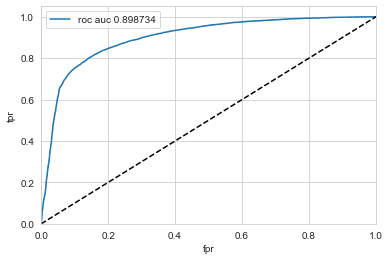

In [112]:
#Logistic Regression Roc train 
drawroc(lr_Train_res.churn,lr_Train_res.churn_prob)

In [113]:
#find ideal cutoff
x=[i/10 for i in range(10)]
for n in x:
    lr_Train_res[n]=lr_Train_res.churn_prob.apply(lambda x: 1 if x>n else 0)
lr_Train_res.head()

,churn,churn_prob,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.124567,1,1,0,0,0,0,0,0,0,0
1,0,0.525074,1,1,1,1,1,1,0,0,0,0
2,0,0.128628,1,1,0,0,0,0,0,0,0,0
3,0,0.000845,1,0,0,0,0,0,0,0,0,0
4,0,0.035420,1,0,0,0,0,0,0,0,0,0


In [114]:
cutoff=find_cutoff(lr_Train_res)
cutoff

,prob,specificity,sensitivity,accuracy
0.0,0.0,0.000000,1.000000,0.500000
0.1,0.1,0.400384,0.975031,0.687708
0.2,0.2,0.532807,0.949647,0.741227
0.3,0.3,0.633513,0.924003,0.778758
0.4,0.4,0.713974,0.890365,0.802170
0.5,0.5,0.788414,0.853353,0.820884
0.6,0.6,0.854184,0.803675,0.828930
0.7,0.7,0.909884,0.737282,0.823583
0.8,0.8,0.954267,0.575685,0.764976
0.9,0.9,0.986763,0.168293,0.577528


<AxesSubplot:xlabel='prob'>

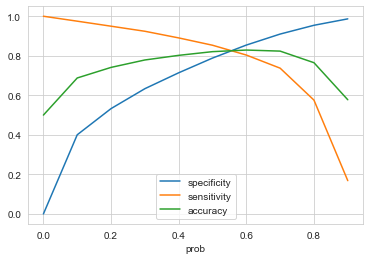

In [115]:
cutoff.plot(x='prob',y=['specificity','sensitivity','accuracy'])
#ideal cutoff is 0.5

In [116]:
lr_Train_res['predicted']=lr_Train_res.churn_prob.apply(lambda x:1 if x>0.5 else 0)

In [117]:
lrTraindf=metri(lr_Train_res)

accuracy is 0.8208835132890365
senstivity is 0.8533534053156147
Specificity is 0.7884136212624585


In [118]:
X_test[['roam_ic_mou_8', 'roam_og_mou_8', 'loc_og_t2c_mou_8', 'loc_og_mou_6',
       'std_og_t2t_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6',
       'std_og_t2f_mou_7', 'spl_og_mou_8', 'og_others_8', 'total_og_mou_6',
       'total_og_mou_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_8',
       'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_8',
       'std_ic_t2t_mou_8', 'std_ic_t2m_mou_8', 'std_ic_t2f_mou_8',
       'spl_ic_mou_8', 'isd_ic_mou_8', 'ic_others_8', 'max_rech_amt_8',
       'last_day_rch_amt_8', 'total_rech_data_8', 'max_rech_data_8',
       'count_rech_3g_8', 'vol_2g_mb_8', 'monthly_2g_8', 'vbc_3g_8',
       'total_rech_amount_data_8', 'avg_arpu_6_7', 'offnet_mou_6_7',
       'roam_ic_mou_6_7', 'roam_og_mou_6_7', 'loc_og_t2c_mou_6_7',
       'spl_og_mou_6_7', 'og_others_6_7', 'std_ic_t2t_mou_6_7',
       'std_ic_t2m_mou_6_7', 'std_ic_t2f_mou_6_7', 'spl_ic_mou_6_7',
       'isd_ic_mou_6_7', 'ic_others_6_7', 'total_rech_num_6_7',
       'max_rech_amt_6_7', 'last_day_rch_amt_6_7', 'total_rech_data_6_7',
       'max_rech_data_6_7', 'count_rech_3g_6_7', 'vol_2g_mb_6_7',
       'monthly_2g_6_7', 'vbc_3g_6_7', '2-5', '>5']]=scaler.transform(X_test[['roam_ic_mou_8', 'roam_og_mou_8', 'loc_og_t2c_mou_8', 'loc_og_mou_6',
       'std_og_t2t_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6',
       'std_og_t2f_mou_7', 'spl_og_mou_8', 'og_others_8', 'total_og_mou_6',
       'total_og_mou_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_8',
       'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_8',
       'std_ic_t2t_mou_8', 'std_ic_t2m_mou_8', 'std_ic_t2f_mou_8',
       'spl_ic_mou_8', 'isd_ic_mou_8', 'ic_others_8', 'max_rech_amt_8',
       'last_day_rch_amt_8', 'total_rech_data_8', 'max_rech_data_8',
       'count_rech_3g_8', 'vol_2g_mb_8', 'monthly_2g_8', 'vbc_3g_8',
       'total_rech_amount_data_8', 'avg_arpu_6_7', 'offnet_mou_6_7',
       'roam_ic_mou_6_7', 'roam_og_mou_6_7', 'loc_og_t2c_mou_6_7',
       'spl_og_mou_6_7', 'og_others_6_7', 'std_ic_t2t_mou_6_7',
       'std_ic_t2m_mou_6_7', 'std_ic_t2f_mou_6_7', 'spl_ic_mou_6_7',
       'isd_ic_mou_6_7', 'ic_others_6_7', 'total_rech_num_6_7',
       'max_rech_amt_6_7', 'last_day_rch_amt_6_7', 'total_rech_data_6_7',
       'max_rech_data_6_7', 'count_rech_3g_6_7', 'vol_2g_mb_6_7',
       'monthly_2g_6_7', 'vbc_3g_6_7', '2-5', '>5']])

In [119]:
X_test_new=X_test[['std_og_t2t_mou_7', 'total_og_mou_8', 'loc_ic_t2t_mou_8',
       'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_8', 'std_ic_t2t_mou_8',
       'spl_ic_mou_8', 'last_day_rch_amt_8', 'total_rech_data_8',
       'count_rech_3g_8', 'vol_2g_mb_8', 'monthly_2g_8', 'vbc_3g_8',
       'offnet_mou_6_7', 'count_rech_3g_6_7']]


In [120]:
#Logistic Regression Test on test set
lr_Test_res=pd.DataFrame({'churn':y_test.values})
lr_Test_res['churn_prob']=lr_model1.predict(sm.add_constant(X_test_new)).values
lr_Test_res['predicted']=lr_Test_res.churn_prob.apply(lambda x:1 if x>0.5 else 0)
lrTestdf=metri(lr_Test_res)

accuracy is 0.7837747607389273
senstivity is 0.8465753424657534
Specificity is 0.7782218992248062


C:\Users\manis\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


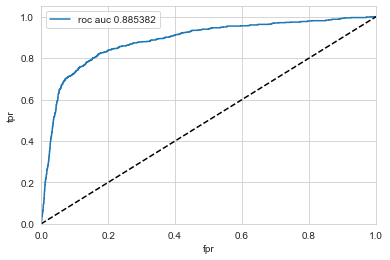

In [121]:
#Logistic Regression Roc test
drawroc(lr_Test_res.churn,lr_Test_res.churn_prob)

In [122]:
overAllScore.loc['LRTrainWithoutPCA']=[lrTraindf.accuracy[0],lrTraindf.sens[0],lrTraindf.spec[0]]
overAllScore.loc['LRTestWithoutPCA']=[lrTestdf.accuracy[0],lrTestdf.sens[0],lrTestdf.spec[0]]
overAllScore

,accuracy,sensitivity,specificity
TreeTrainWithoutPCA,0.779407,0.723681,0.835133
TreeTestWithoutPCA,0.826842,0.723288,0.835998
RFTrainWithoutPCA,0.807049,0.896802,0.717297
RFTestWithoutPCA,0.724015,0.849315,0.712936
LRTrainWithoutPCA,0.820884,0.853353,0.788414
LRTestWithoutPCA,0.783775,0.846575,0.778222


# Perform XGBoost Without PCA


In [123]:
import xgboost as xgb
xb=xgb.XGBClassifier()
params={'learning_rate': [0.1,.2,.3,.4],
              'max_depth': [5,6,7,8],
              'n_estimators': [5,10,15,20,100]}
xgb_model=GridSearchCV(estimator=xb,cv=5,param_grid=params, n_jobs=-1,scoring='recall')
xgb_model.fit(X_train_smote,y_train_smote)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2, 0.3, 0.4],
                         'max_depth': [5, 6, 7, 8],
                         'n_estimators': [5, 10, 15, 20, 100]},
             scoring='recall')

In [124]:
xgb_model.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [125]:
xgb_model.best_score_

0.9600827826572542

In [126]:
xb=xgb.XGBClassifier()
params={'learning_rate': [0.1],
              'max_depth': [8,12,14,16],
              'n_estimators': [100,200,300,400]}
xgb_model=GridSearchCV(estimator=xb,cv=5,param_grid=params, n_jobs=-1,scoring='recall')
xgb_model.fit(X_train_smote,y_train_smote)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1], 'max_depth': [8, 12, 14, 16],
                         'n_estimators': [100, 200, 300, 400]},
             scoring='recall')

In [127]:
xgb_model.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=16, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [128]:
xgb_model.best_score_

0.9666231947217028

In [129]:
xb=xgb.XGBClassifier(learning_rate=0.1,n_estimators=50,max_depth=1,max_features = 0.5)

xb.fit(X_train_smote,y_train_smote)

[17:32:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=1, max_features=0.5, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, ...)

In [130]:
#Evaluate model
xg_Train_res=pd.DataFrame({'churn':y_train_smote.values})
xg_Train_res['churn_prob']=xb.predict_proba(X_train_smote)[:,1]
xg_Train_res.head()

,churn,churn_prob
0,0,0.147138
1,0,0.192202
2,0,0.280500
3,0,0.074271
4,0,0.189197


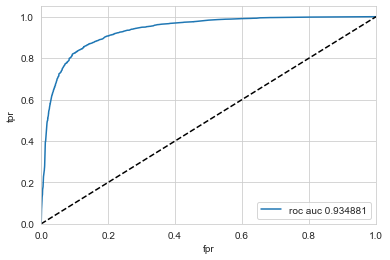

In [131]:
#XG Boost Regression Roc train 
drawroc(xg_Train_res.churn,xg_Train_res.churn_prob)

In [132]:
#find ideal cutoff
x=[i/10 for i in range(10)]
for n in x:
    xg_Train_res[n]=xg_Train_res.churn_prob.apply(lambda x: 1 if x>n else 0)
xg_Train_res.head()

,churn,churn_prob,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.147138,1,1,0,0,0,0,0,0,0,0
1,0,0.192202,1,1,0,0,0,0,0,0,0,0
2,0,0.280500,1,1,1,0,0,0,0,0,0,0
3,0,0.074271,1,0,0,0,0,0,0,0,0,0
4,0,0.189197,1,1,0,0,0,0,0,0,0,0


In [133]:
cutoff=find_cutoff(xg_Train_res)
cutoff

,prob,specificity,sensitivity,accuracy
0.0,0.0,0.000000,1.000000,0.500000
0.1,0.1,0.121833,0.999481,0.560657
0.2,0.2,0.453540,0.987645,0.720593
0.3,0.3,0.680700,0.952398,0.816549
0.4,0.4,0.807205,0.903603,0.855404
0.5,0.5,0.884551,0.839961,0.862256
0.6,0.6,0.932153,0.762303,0.847228
0.7,0.7,0.957589,0.673848,0.815718
0.8,0.8,0.977938,0.535403,0.756670
0.9,0.9,0.994549,0.178883,0.586716


<AxesSubplot:xlabel='prob'>

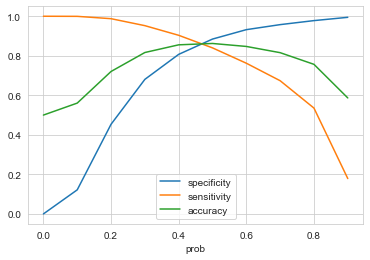

In [134]:
cutoff.plot(x='prob',y=['specificity','sensitivity','accuracy'])
#ideal cutoff is 0.55

In [135]:
xg_Train_res['predicted']=xg_Train_res.churn_prob.apply(lambda x:1 if x>0.42 else 0)

In [136]:
xgTraindf=metri(xg_Train_res)

accuracy is 0.857843646179402
senstivity is 0.8875103820598007
Specificity is 0.8281769102990033


In [137]:
#XgBooster Test on test set
xg_Test_res=pd.DataFrame({'churn':y_test.values})
xg_Test_res['churn_prob']=xb.predict_proba(X_test)[:,1]
xg_Test_res['predicted']=xg_Test_res.churn_prob.apply(lambda x:1 if x>0.42 else 0)
xbTestdf=metri(xg_Test_res)

accuracy is 0.8268417538393056
senstivity is 0.8
Specificity is 0.8292151162790697


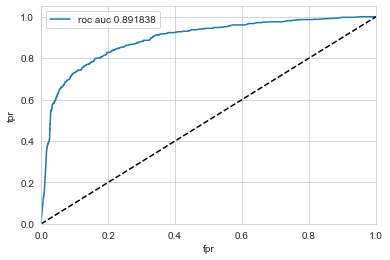

In [138]:
#XG Boost Regression Roc test 
drawroc(xg_Test_res.churn,xg_Test_res.churn_prob)

In [139]:
overAllScore.loc['XGTrainWithoutPCA']=[xgTraindf.accuracy[0],xgTraindf.sens[0],xgTraindf.spec[0]]
overAllScore.loc['XGTestWithoutPCA']=[xbTestdf.accuracy[0],xbTestdf.sens[0],xbTestdf.spec[0]]
overAllScore

,accuracy,sensitivity,specificity
TreeTrainWithoutPCA,0.779407,0.723681,0.835133
TreeTestWithoutPCA,0.826842,0.723288,0.835998
RFTrainWithoutPCA,0.807049,0.896802,0.717297
RFTestWithoutPCA,0.724015,0.849315,0.712936
LRTrainWithoutPCA,0.820884,0.853353,0.788414
LRTestWithoutPCA,0.783775,0.846575,0.778222
XGTrainWithoutPCA,0.857844,0.887510,0.828177
XGTestWithoutPCA,0.826842,0.800000,0.829215


#Perform PCA

In [140]:
pc=PCA()
pc.fit(X_train_smote)

PCA()

In [141]:
pc.components_

array([[ 4.19732361e-04,  9.96307246e-04,  2.78301365e-04, ...,
        -9.96570642e-05,  8.94947144e-01, -4.45742396e-01],
       [-4.18207013e-04, -1.35885150e-03,  1.24231222e-03, ...,
         9.37522149e-03,  4.44494942e-01,  8.90292734e-01],
       [ 5.23427537e-03,  1.00512386e-02,  7.13195246e-03, ...,
        -1.23077911e-01,  1.20138750e-02,  4.26008546e-02],
       ...,
       [-1.38408632e-03,  6.88038820e-03,  1.94470783e-03, ...,
         6.59046130e-04,  1.26249034e-04,  1.66050714e-04],
       [-7.28870027e-04,  1.92433537e-03, -4.04139974e-03, ...,
        -5.47304093e-04,  6.83340129e-05,  1.03396320e-04],
       [-2.38218066e-04,  3.33444016e-03, -2.20028788e-02, ...,
        -7.85881277e-04,  1.39808088e-04,  3.21887391e-04]])

In [142]:
pc.explained_variance_ratio_

array([5.01368146e-01, 2.97310989e-01, 4.53762758e-02, 2.44373945e-02,
       1.64763076e-02, 1.46799089e-02, 1.10111907e-02, 8.89164325e-03,
       7.82121684e-03, 6.67790008e-03, 6.22984616e-03, 5.80041413e-03,
       4.31494277e-03, 4.18295167e-03, 3.37423053e-03, 3.23280449e-03,
       3.08534719e-03, 2.92943167e-03, 2.59189529e-03, 2.50461334e-03,
       2.29242393e-03, 2.07465660e-03, 1.96062262e-03, 1.89811980e-03,
       1.79935972e-03, 1.69389492e-03, 1.62972884e-03, 1.27964601e-03,
       1.13048263e-03, 1.01141194e-03, 9.00045516e-04, 8.48646455e-04,
       8.25085177e-04, 7.81267094e-04, 7.13142213e-04, 7.00833310e-04,
       6.76113456e-04, 6.43666981e-04, 5.20582276e-04, 4.84173168e-04,
       4.38461689e-04, 4.14604653e-04, 4.08945515e-04, 3.40422052e-04,
       3.15982877e-04, 2.82152944e-04, 2.75163044e-04, 2.71164030e-04,
       1.93044481e-04, 1.78472291e-04, 1.72340935e-04, 1.67721800e-04,
       1.42531324e-04, 1.08110662e-04, 7.62394421e-05, 5.32902452e-05])

In [143]:
cumsu=np.cumsum(pc.explained_variance_ratio_)


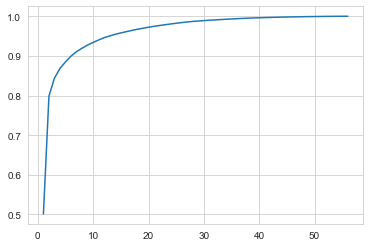

In [144]:
plt.plot(range(1,len(cumsu)+1), cumsu)

In [145]:
pc2 = IncrementalPCA(n_components=6)
X_train_PCA = pc2.fit_transform(X_train_smote)

In [146]:
df_pca = pd.DataFrame(X_train_PCA, columns=["PC1", "PC2","PC3","PC4","PC5","PC6"])
df_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
0,0.767121,0.235673,-0.059239,0.046065,-0.004944,0.032443
1,-0.125416,-0.222500,-0.051859,-0.063673,0.007796,0.020117
2,-0.124439,-0.223167,-0.108508,-0.109325,0.004697,0.037759
3,-0.573017,0.692814,-0.096426,0.149310,0.167922,0.024038
4,-0.123734,-0.216472,-0.179744,-0.030655,0.071529,0.034464


In [147]:
corrmat = np.corrcoef(df_pca.transpose())

<AxesSubplot:>

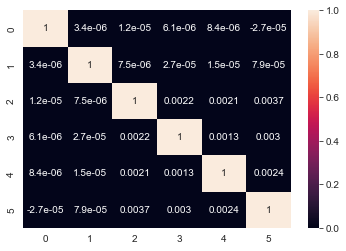

In [148]:

sns.heatmap(corrmat, annot=True)

In [149]:
df_test_pca = pc2.transform(X_test)
df_test_pca.shape

(8986, 6)

In [150]:
#Apply on XG Boost
xb=xgb.XGBClassifier(learning_rate=0.1,n_estimators=700,max_depth=3)

xb.fit(X_train_PCA,y_train_smote)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=700,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [151]:
#Evaluate model
xg_Train_res_pca=pd.DataFrame({'churn':y_train_smote.values})
xg_Train_res_pca['churn_prob']=xb.predict_proba(X_train_PCA)[:,1]
xg_Train_res_pca.head()

,churn,churn_prob
0,0,0.035522
1,0,0.537691
2,0,0.083111
3,0,0.002470
4,0,0.151091


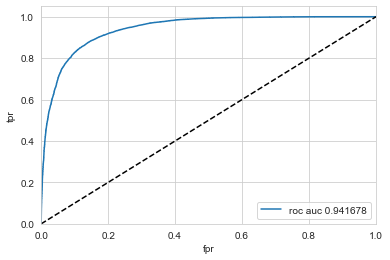

In [152]:
#XG Boost Regression Roc train 
drawroc(xg_Train_res_pca.churn,xg_Train_res_pca.churn_prob)

In [153]:
#find ideal cutoff
x=[i/10 for i in range(10)]
for n in x:
    xg_Train_res_pca[n]=xg_Train_res_pca.churn_prob.apply(lambda x: 1 if x>n else 0)
xg_Train_res_pca.head()

,churn,churn_prob,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.035522,1,0,0,0,0,0,0,0,0,0
1,0,0.537691,1,1,1,1,1,1,0,0,0,0
2,0,0.083111,1,0,0,0,0,0,0,0,0,0
3,0,0.002470,1,0,0,0,0,0,0,0,0,0
4,0,0.151091,1,1,0,0,0,0,0,0,0,0


In [154]:
cutoff=find_cutoff(xg_Train_res_pca)
cutoff 


,prob,specificity,sensitivity,accuracy
0.0,0.0,0.000000,1.000000,0.500000
0.1,0.1,0.477575,0.994394,0.735984
0.2,0.2,0.624637,0.978769,0.801703
0.3,0.3,0.725446,0.951152,0.838299
0.4,0.4,0.802118,0.917307,0.859712
0.5,0.5,0.860050,0.875260,0.867655
0.6,0.6,0.903551,0.822051,0.862801
0.7,0.7,0.938746,0.747404,0.843075
0.8,0.8,0.960756,0.641248,0.801002
0.9,0.9,0.985828,0.451879,0.718854


<AxesSubplot:xlabel='prob'>

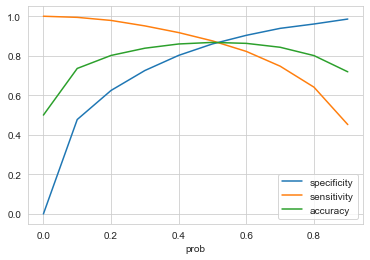

In [155]:
cutoff.plot(x='prob',y=['specificity','sensitivity','accuracy'])
#ideal cutoff is 0.5

In [156]:
xg_Train_res_pca['predicted']=xg_Train_res_pca.churn_prob.apply(lambda x:1 if x>0.5 else 0)

In [157]:
xgTraindf_pca=metri(xg_Train_res_pca)

accuracy is 0.8676546926910299
senstivity is 0.8752595514950167
Specificity is 0.8600498338870431


In [158]:
#XgBooster Test on test set
xg_Test_res_pca=pd.DataFrame({'churn':y_test.values})
xg_Test_res_pca['churn_prob']=xb.predict_proba(df_test_pca)[:,1]
xg_Test_res_pca['predicted']=xg_Test_res_pca.churn_prob.apply(lambda x:1 if x>0.5 else 0)
xbTestdf_pca=metri(xg_Test_res_pca)

accuracy is 0.8257289116403294
senstivity is 0.6712328767123288
Specificity is 0.8393895348837209


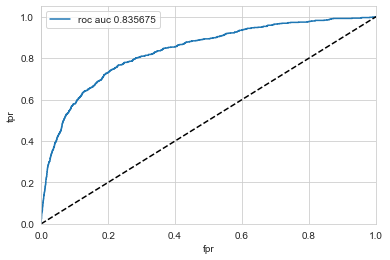

In [159]:
#XG boost Roc test
drawroc(xg_Test_res_pca.churn,xg_Test_res_pca.churn_prob)

In [160]:
overAllScore.loc['XGTrainWithPCA']=[xgTraindf_pca.accuracy[0],xgTraindf_pca.sens[0],xgTraindf_pca.spec[0]]
overAllScore.loc['XGTestWithPCA']=[xbTestdf_pca.accuracy[0],xbTestdf_pca.sens[0],xbTestdf_pca.spec[0]]
overAllScore

,accuracy,sensitivity,specificity
TreeTrainWithoutPCA,0.779407,0.723681,0.835133
TreeTestWithoutPCA,0.826842,0.723288,0.835998
RFTrainWithoutPCA,0.807049,0.896802,0.717297
RFTestWithoutPCA,0.724015,0.849315,0.712936
LRTrainWithoutPCA,0.820884,0.853353,0.788414
LRTestWithoutPCA,0.783775,0.846575,0.778222
XGTrainWithoutPCA,0.857844,0.887510,0.828177
XGTestWithoutPCA,0.826842,0.800000,0.829215
XGTrainWithPCA,0.867655,0.875260,0.860050
XGTestWithPCA,0.825729,0.671233,0.839390


##### Random forest with PCA

In [161]:
rf_model=RandomForestClassifier()
params={'n_estimators':[3,5,6,9],'max_depth':[25,30,35],'max_features':[.9,1],'min_samples_split':[.3]}
rf_m1=GridSearchCV(estimator=rf_model,param_grid=params,cv=5,verbose=-1,n_jobs=-1,scoring='recall')
rf_m1.fit(X_train_PCA,y_train_smote)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [25, 30, 35], 'max_features': [0.9, 1],
                         'min_samples_split': [0.3],
                         'n_estimators': [3, 5, 6, 9]},
             scoring='recall', verbose=-1)

In [162]:
rf_m1.best_estimator_

RandomForestClassifier(max_depth=30, max_features=0.9, min_samples_split=0.3,
                       n_estimators=6)

In [163]:
rf_m1.best_score_

0.8128651218898895

In [164]:
rf_model=RandomForestClassifier()
params={'n_estimators':[27,30,50,80],'max_depth':[10,5,19],'max_features':[.9],'min_samples_split':[.1,.2,.3]}
rf_m1=GridSearchCV(estimator=rf_model,param_grid=params,cv=5,verbose=-1,n_jobs=-1,scoring='recall')
rf_m1.fit(X_train_PCA,y_train_smote)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [10, 5, 19], 'max_features': [0.9],
                         'min_samples_split': [0.1, 0.2, 0.3],
                         'n_estimators': [27, 30, 50, 80]},
             scoring='recall', verbose=-1)

In [165]:
rf_m1.best_estimator_

RandomForestClassifier(max_depth=5, max_features=0.9, min_samples_split=0.2,
                       n_estimators=30)

In [166]:
rf_m1.best_score_

0.8152526965138087

In [167]:

rf_model=RandomForestClassifier()
params={'n_estimators':[50,55,60,65],'max_depth':[7,8,10],'max_features':[.9],'min_samples_split':[.2]}
rf_m1=GridSearchCV(estimator=rf_model,param_grid=params,cv=5,verbose=-1,n_jobs=-1,scoring='recall')
rf_m1.fit(X_train_PCA,y_train_smote)


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [7, 8, 10], 'max_features': [0.9],
                         'min_samples_split': [0.2],
                         'n_estimators': [50, 55, 60, 65]},
             scoring='recall', verbose=-1)

In [168]:
rf_m1.best_score_

0.8156681325309485

In [169]:
rf_m1.best_estimator_

RandomForestClassifier(max_depth=8, max_features=0.9, min_samples_split=0.2,
                       n_estimators=55)

In [170]:
#Evaluate model
rf_Train_res_pca=pd.DataFrame({'churn':y_train_smote.values})
rf_Train_res_pca['churn_prob']=rf_m1.best_estimator_.predict_proba(X_train_PCA)[:,1]
rf_Train_res_pca.head()

,churn,churn_prob
0,0,0.127570
1,0,0.667342
2,0,0.568667
3,0,0.093422
4,0,0.568667


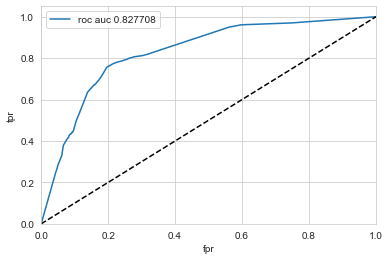

In [171]:
#Random Forest  Roc train 
drawroc(rf_Train_res_pca.churn,rf_Train_res_pca.churn_prob)

In [172]:
#find ideal cutoff
x=[i/10 for i in range(10)]
for n in x:
    rf_Train_res_pca[n]=rf_Train_res_pca.churn_prob.apply(lambda x: 1 if x>n else 0)
rf_Train_res_pca.head()

,churn,churn_prob,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.127570,1,1,0,0,0,0,0,0,0,0
1,0,0.667342,1,1,1,1,1,1,1,0,0,0
2,0,0.568667,1,1,1,1,1,1,0,0,0,0
3,0,0.093422,1,0,0,0,0,0,0,0,0,0
4,0,0.568667,1,1,1,1,1,1,0,0,0,0


In [173]:
cutoff=find_cutoff(rf_Train_res_pca)
cutoff 


,prob,specificity,sensitivity,accuracy
0.0,0.0,0.000000,1.000000,0.500000
0.1,0.1,0.252128,0.969944,0.611036
0.2,0.2,0.407132,0.959718,0.683425
0.3,0.3,0.410299,0.958679,0.684489
0.4,0.4,0.679662,0.819404,0.749533
0.5,0.5,0.680907,0.818574,0.749740
0.6,0.6,0.785766,0.772425,0.779096
0.7,0.7,0.909572,0.436254,0.672913
0.8,0.8,0.935164,0.365656,0.650410
0.9,0.9,1.000000,0.000000,0.500000


<AxesSubplot:xlabel='prob'>

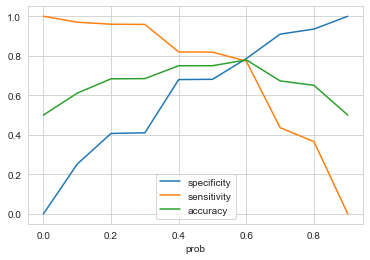

In [174]:
cutoff.plot(x='prob',y=['specificity','sensitivity','accuracy'])
#ideal cutoff is 0.6

In [175]:
rf_Train_res_pca['predicted']=rf_Train_res_pca.churn_prob.apply(lambda x:1 if x>0.6 else 0)

In [176]:
rfTraindf_pca=metri(rf_Train_res_pca)

accuracy is 0.7790957225913622
senstivity is 0.7724252491694352
Specificity is 0.785766196013289


In [177]:
#Random forest Test on test set
rf_Test_res_pca=pd.DataFrame({'churn':y_test.values})
rf_Test_res_pca['churn_prob']=rf_m1.best_estimator_.predict_proba(df_test_pca)[:,1]
rf_Test_res_pca['predicted']=rf_Test_res_pca.churn_prob.apply(lambda x:1 if x>0.6 else 0)
rfTestdf_pca=metri(rf_Test_res_pca)

accuracy is 0.7595148008012463
senstivity is 0.5068493150684932
Specificity is 0.7818556201550387


In [178]:
overAllScore.loc['RFTrainWithPCA']=[rfTraindf_pca.accuracy[0],rfTraindf_pca.sens[0],rfTraindf_pca.spec[0]]
overAllScore.loc['RFTestWithPCA']=[rfTestdf_pca.accuracy[0],rfTestdf_pca.sens[0],rfTestdf_pca.spec[0]]
overAllScore

,accuracy,sensitivity,specificity
TreeTrainWithoutPCA,0.779407,0.723681,0.835133
TreeTestWithoutPCA,0.826842,0.723288,0.835998
RFTrainWithoutPCA,0.807049,0.896802,0.717297
RFTestWithoutPCA,0.724015,0.849315,0.712936
LRTrainWithoutPCA,0.820884,0.853353,0.788414
LRTestWithoutPCA,0.783775,0.846575,0.778222
XGTrainWithoutPCA,0.857844,0.887510,0.828177
XGTestWithoutPCA,0.826842,0.800000,0.829215
XGTrainWithPCA,0.867655,0.875260,0.860050
XGTestWithPCA,0.825729,0.671233,0.839390


Conclusion - XG Boost model without PCA gives best results. 

As per the interpretable models important factors to consider reduce churn are:
    'std_og_t2t_mou_7'
    'total_og_mou_8'
    'loc_ic_t2t_mou_8'
    'loc_ic_t2m_mou_8'
    'loc_ic_t2f_mou_8'
    'std_ic_t2t_mou_8'
    'spl_ic_mou_8'
    'last_day_rch_amt_8'
    'total_rech_data_8'
    'count_rech_3g_8'
    'vol_2g_mb_8'
    'monthly_2g_8'
    'vbc_3g_8' 
    'offnet_mou_6_7'
    'count_rech_3g_6_7'